# Imports

In [1]:
import numpy as np
import itertools
import copy
import time
import networkx as nx
import pandas as pd
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# Create Contingency Matrix

In [17]:
def generate_random_contingency_matrix(num_clusters_method_a, num_clusters_method_b, constant_sum):
    random_matrix = np.zeros((num_clusters_method_a, num_clusters_method_b), dtype=int)
    cluster_a_list = np.zeros((num_clusters_method_a), dtype=int)

    for row_index in range(constant_sum):
        random_index = np.random.randint(0, num_clusters_method_a)
        cluster_a_list[random_index] += 1

    for row_index in range(num_clusters_method_a):
        for _ in range(cluster_a_list[row_index]):
            random_index = np.random.randint(0, num_clusters_method_b)
            random_matrix[row_index, random_index] += 1

    return random_matrix


In [23]:
num_clusters_method_a = 4
num_clusters_method_b = 4
total_members = 100

contingency_matrix = generate_random_contingency_matrix(num_clusters_method_a, num_clusters_method_b, total_members)

print("Contingency Matrix:\n", contingency_matrix)

Contingency Matrix:
 [[ 7  5  3  4]
 [10  4  5  4]
 [ 7  7  7  8]
 [12  5  9  3]]


# Brute Force Matching

In [24]:
def brute_force_matching(matrix):
    num_clusters_a = matrix.shape[0]

    best_matching = None
    best_matching_sum = 0

    for permutation in list(itertools.permutations(range(num_clusters_a))):
        matching_sum = np.sum(matrix[np.arange(num_clusters_a), permutation])
        if matching_sum > best_matching_sum:
            best_matching_sum = matching_sum
            best_matching = permutation

    return best_matching, best_matching_sum

In [25]:
best_matching, best_matching_sum = brute_force_matching(contingency_matrix)
best_matching = [(index, number) for index, number in enumerate(best_matching)]
print("Best Matching: ", best_matching)
print("Best Matching Sum: ", best_matching_sum)

Best Matching:  [(0, 1), (1, 0), (2, 3), (3, 2)]
Best Matching Sum:  32


# Stable Matching Based Clustering Evaluation

In [26]:
class stable_matcher:

    def __init__(self, matrix):
        self.ready = False
        self.pairs = []
        self.matrix = np.zeros((matrix.shape[0], matrix.shape[1]), dtype=int)
        self.matrix = copy.deepcopy(matrix)

    def create_matrix(self, matrix):
        self.ready = False
        self.matrix = np.zeros((matrix.shape[0], matrix.shape[1]), dtype=int)
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                self.matrix[i, j] = matrix[i, j]

    def score(self):
        if self.ready:
            return np.sum(self.matrix[[pair[0] for pair in self.pairs], [pair[1] for pair in self.pairs]])
        return -1

    def find_pairs(self):

        def priorities(matrix):

            def rank(numbers):
                sorted_indices = np.argsort(numbers)[::-1]
                return sorted_indices

            output = []
            for comm1 in range(matrix.shape[0]):
                temp = []
                for comm2 in range(matrix.shape[1]):
                    common = matrix[comm1,comm2]
                    temp.append(common)
                output.append(rank(temp))
            return output

        def find_pair(List, value):
            for pair in List:
                if pair[1] == value:
                    return pair[0]

        def find_index_of_value_in_array(arr, target_value):
            indices = np.where(arr == target_value)[0]
            if indices.size > 0:
                return indices[0]
            else:
                return 

        self.ready = True
        self.pairs = []
        chooser = range(self.matrix.shape[0])
        wanted = range(self.matrix.shape[1])
        unmatched_chooser = [index for index in range(len(chooser))]
        unmatched_wanted = [index for index in range(len(wanted))]
        prior_chooser = priorities(self.matrix)
        prior_wanted = priorities(self.matrix.T)
        while(len(unmatched_chooser)):
            comm1 = unmatched_chooser.pop()
            for matching_pred in prior_chooser[comm1]:
                if matching_pred in unmatched_wanted:
                    self.pairs.append([comm1, matching_pred])
                    unmatched_wanted.remove(matching_pred)
                    break
                else:
                    matched_with_wanted = find_pair(self.pairs,matching_pred)
                    if find_index_of_value_in_array(prior_wanted[matching_pred], comm1) < find_index_of_value_in_array(prior_wanted[matching_pred], matched_with_wanted):
                        self.pairs.remove([matched_with_wanted, matching_pred])
                        self.pairs.append([comm1, matching_pred])
                        unmatched_chooser.append(matched_with_wanted)
                        break
        return self.pairs

In [27]:
stable = stable_matcher(contingency_matrix)
pairs = stable.find_pairs()
best_score =  stable.score()

print("Best Matching Based on Stable Matching: ", sorted(pairs, key=lambda x: x[0]))
print("Best Matching Sum Based on Stable Matching: ", best_score)

Best Matching Based on Stable Matching:  [[0, 1], [1, 2], [2, 3], [3, 0]]
Best Matching Sum Based on Stable Matching:  30


# Maximum Weighted Matching

In [28]:

class maximum_weighted_matching:

    def __init__(self, matrix):
        self.ready = False
        self.pairs = []
        self.num_clusters_method_a = matrix.shape[0]
        self.num_clusters_method_b = matrix.shape[1]
        self.graph = nx.Graph()
        self.graph.add_nodes_from([f'A{i}' for i in range(num_clusters_method_a)], bipartite=0)
        self.graph.add_nodes_from([f'B{i}' for i in range(num_clusters_method_b)], bipartite=1)
        self.RB_top = {n for n, d in self.graph.nodes(data=True) if d["bipartite"] == 0}
        for i in range(self.num_clusters_method_a):
            for j in range(self.num_clusters_method_b):
                if matrix[i][j] > 0:
                    self.graph.add_edge(f'A{i}', f'B{j}', weight=matrix[i][j])

    def create_biparticle_graph_from_contingency_matrix(self, matrix):
        self.ready = False
        self.pairs = []
        self.num_clusters_method_a = matrix.shape[0]
        self.num_clusters_method_b = matrix.shape[1]
        self.graph = nx.Graph()
        self.graph.add_nodes_from([f'A{i}' for i in range(num_clusters_method_a)], bipartite=0)
        self.graph.add_nodes_from([f'B{i}' for i in range(num_clusters_method_b)], bipartite=1)
        self.RB_top = {n for n, d in self.graph.nodes(data=True) if d["bipartite"] == 0}
        for i in range(self.num_clusters_method_a):
            for j in range(self.num_clusters_method_b):
                if matrix[i][j] > 0:
                    self.graph.add_edge(f'A{i}', f'B{j}', weight=matrix[i][j])

    def score(self):
        if self.ready:
            score = 0
            for i in self.pairs:
                score += self.graph[i[0]][i[1]]['weight'] # output of mximum matching in nx is transposed.
                # For example instead of (A0, B1) it returns (B0, A1). So I calculate score in this way to solve this issue.
            return score
        return -1

    def find_pairs(self):
        self.ready = True
        self.pairs = []
        matching = nx.max_weight_matching(self.graph)
        # matching = nx.algorithms.bipartite.maximum_matching(self.graph, self.RB_top)
        self.pairs = list(matching)
        return self.pairs

In [29]:
matcher = maximum_weighted_matching(contingency_matrix)
pairs = matcher.find_pairs()
best_score =  matcher.score()

print("Best Matching Based on Maximum Weighted Matching: ", sorted(pairs, key=lambda x: x[1]))
print("Best Matching Sum Based on Maximum Weighted Matching: ", best_score)

Best Matching Based on Maximum Weighted Matching:  [('B0', 'A1'), ('A0', 'B1'), ('A3', 'B2'), ('A2', 'B3')]
Best Matching Sum Based on Maximum Weighted Matching:  32


# Maximum Match Measure

In [39]:

class maximum_match_measure:

    def __init__(self, matrix):
        self.matrix = np.zeros((matrix.shape[0], matrix.shape[1]), dtype=int)
        self.matrix = copy.deepcopy(matrix)

    def create_matrix(self, matrix):
        self.matrix = np.zeros((matrix.shape[0], matrix.shape[1]), dtype=int)
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                self.matrix[i, j] = matrix[i, j]

    def score(self):
        def remove_row_col(arr, i, j):
            arr = np.delete(arr, i, axis=0)
            arr = np.delete(arr, j, axis=1)
            return arr
        temp_matrix = copy.deepcopy(self.matrix)
        score = 0
        while(not 0 in temp_matrix.shape):
            flattened_index = np.argmax(temp_matrix)
            row, col = np.unravel_index(flattened_index, temp_matrix.shape)
            score += temp_matrix[row, col]
            temp_matrix = remove_row_col(temp_matrix, row, col)
        return score

In [40]:
matcher = maximum_match_measure(contingency_matrix)
best_score =  matcher.score()

print("Best Matching Sum Based on Maximum Match Measure: ", best_score)

Best Matching Sum Based on Maximum Match Measure:  30


# Centroid Ratio

In [84]:
class centroid_ratio:

    def __init__(self, df, ground_true, predicted):
        self.df = copy.deepcopy(df)
        self.ground_true = copy.deepcopy(ground_true)
        self.predicted = copy.deepcopy(predicted)
        self.pairs = []
        self.ready = False

        
    def score(self):
        def remove_row_col(arr, i, j):
            arr = np.delete(arr, i, axis=0)
            arr = np.delete(arr, j, axis=1)
            return arr
        def old_row_calc(deleted_row, new_row):
            ls = deleted_row[::-1]
            for i in ls:
                if i <= new_row:
                    new_row += 1
            return new_row
        def old_col_calc(deleted_col, new_col):
            ls = deleted_col[::-1]
            for i in ls:
                if i <= new_col:
                    new_col += 1
            return new_col
        def create_contingency_matrix(ground_true_unique, predicted_unique):
            contingency_matrix = np.zeros((len(ground_true_unique), len(predicted_unique)), dtype=int)
            for i, label1 in enumerate(ground_true_unique):
              for j, label2 in enumerate(predicted_unique):
                contingency_matrix[i, j] = np.sum((self.ground_true == label1) & (self.predicted == label2))
            return contingency_matrix

        ground_true_list = []
        predicted_list = []
        true_unique = self.ground_true.unique()
        predicted_unique = np.unique(self.predicted)
        contingency_matrix = create_contingency_matrix(true_unique, predicted_unique)

        for i in true_unique:
            ground_true_list.append(self.df.iloc[self.ground_true[self.ground_true == i].index, :].mean())
        for i in predicted_unique:
            predicted_list.append(self.df.iloc[self.predicted == i, :].mean()) 
        ground_true_array = np.array(ground_true_list)
        predicted_array = np.array(predicted_list)
        distance_matrix = cdist(ground_true_array, predicted_array, metric='euclidean')   
        temp_matrix = copy.deepcopy(distance_matrix)
        deleted_col = []
        deleted_row = []
        score = 0
        while(not 0 in temp_matrix.shape):
            flattened_index = np.argmin(temp_matrix)
            row, col = np.unravel_index(flattened_index, temp_matrix.shape)
            old_row = old_row_calc(deleted_row, row)
            old_col = old_col_calc(deleted_col, col)
            deleted_col.append(col)
            deleted_row.append(row)
            score += contingency_matrix[old_row, old_col]
            temp_matrix = remove_row_col(temp_matrix, row, col)
        return score

In [85]:
df = pd.read_csv("./Data/Iris.csv")
ground = df.iloc[:,5]
predicted = np.zeros((len(ground)), dtype=int)
for i in range(len(ground)):
    random = np.random.randint(0, len(ground.unique()))
    predicted[i] = random

df = df.iloc[:, 1:5]
model = centroid_ratio(df, ground, predicted)
score = model.score()
print("Best Matching Sum Based on Centroid Ration: ", best_score)

Best Matching Sum Based on Centroid Ration:  30


# Test On Real Datasets

In [36]:
def distribution_plotter(samples, number_of_communities):
    plt.hist(samples, bins=np.arange(1, number_of_communities+2)-0.5, edgecolor='black')
    plt.xticks(range(1, number_of_communities+2))
    plt.xlabel('Number')
    plt.ylabel('Frequency')
    plt.title('Histogram of Distribution')
    plt.show()

In [39]:
def uniform_distribution_data_generator(number_of_communities, number_of_data_rows):

    numbers = np.arange(1, number_of_communities+1)
    samples = np.random.choice(numbers, size=number_of_data_rows, replace=True)
    return samples

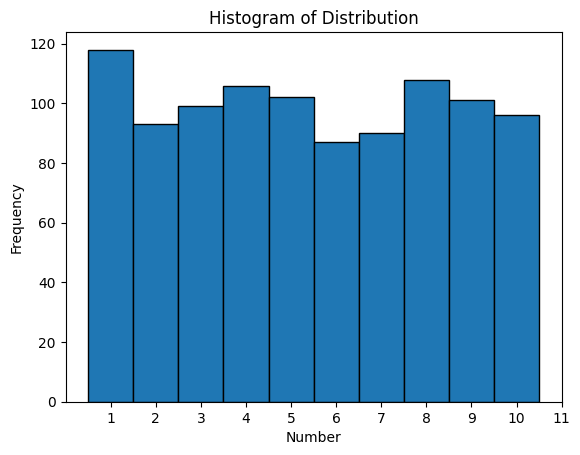

In [40]:
data = uniform_distribution_data_generator(10, 1000)
distribution_plotter(data, 10)

In [45]:
def guassian_distribution_data_generator(number_of_communities, number_of_data_rows, mean, std):

    samples = np.random.normal(loc=mean, scale=std, size=number_of_data_rows)
    samples = np.round(samples)
    samples = np.clip(samples, 1, number_of_communities)
    return samples

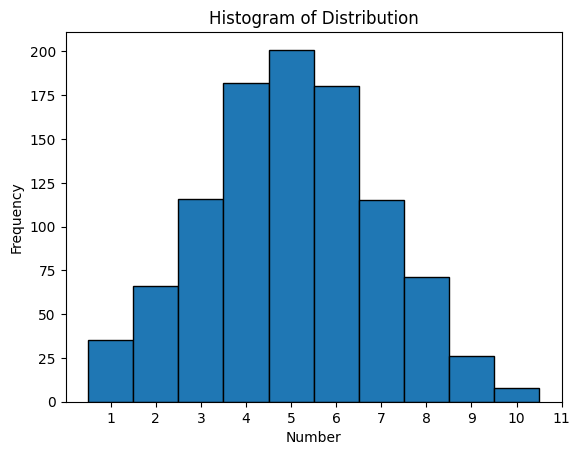

In [46]:
data  = guassian_distribution_data_generator(10,1000,5,2)
distribution_plotter(data, 10)

## Iris

In [50]:
data = pd.read_csv("./Data/Iris.csv")
data

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


In [101]:
def iterative_testing_Iris(num_iterations=100):

    def create_contingency_matrix(ground_true, predicted, ground_true_unique, predicted_unique):
            contingency_matrix = np.zeros((len(ground_true_unique), len(predicted_unique)), dtype=int)
            for i, label1 in enumerate(ground_true_unique):
              for j, label2 in enumerate(predicted_unique):
                contingency_matrix[i, j] = np.sum((ground_true == label1) & (predicted == label2))
            return contingency_matrix

    run_time_maximum_weighted_matching = []
    run_time_stable_matching = []
    run_time_maximum_match_measure = []
    run_time_centroid_ratio = []

    accuracy_stable_matching = []
    accuracy_maximum_match_measure = []
    accuracy_centroid_ratio = []

    df = pd.read_csv("./Data/Iris.csv")
    ground = df.iloc[:,5]

    for epoch in range(num_iterations):

        predicted = np.zeros((len(ground)), dtype=int)
        for i in range(len(ground)):
            random = np.random.randint(0, len(ground.unique()))
            predicted[i] = random
        
        df = df.iloc[:, 1:5]


        centroid = centroid_ratio(df, ground, predicted)

        start = time.time()
        centroid_ratio_score = centroid.score()
        end = time.time()
        time_run_centroid = end-start
        run_time_centroid_ratio.append(time_run_centroid)


        true_unique = ground.unique()
        predicted_unique = np.unique(predicted)
        contingency_matrix = create_contingency_matrix(ground, predicted, true_unique, predicted_unique)


        MMM = maximum_match_measure(contingency_matrix)

        start = time.time()
        MMM_score = MMM.score()
        end = time.time()
        time_run_MMM = end-start
        run_time_maximum_match_measure.append(time_run_MMM)


        stable = stable_matcher(contingency_matrix)

        start = time.time()
        stable.find_pairs()
        end = time.time()
        time_run_stable = end-start
        run_time_stable_matching.append(time_run_stable)

        max_matching = maximum_weighted_matching(contingency_matrix)

        start = time.time()
        max_matching.find_pairs()
        end = time.time()
        time_run_max = end-start
        run_time_maximum_weighted_matching.append(time_run_max)

        accuracy_stable = stable.score() / max_matching.score()
        accuracy_stable_matching.append(accuracy_stable)
        accuracy_centroid = centroid_ratio_score / max_matching.score()
        accuracy_centroid_ratio.append(accuracy_centroid)
        accuracy_MMM = MMM_score / max_matching.score()
        accuracy_maximum_match_measure.append(accuracy_MMM)

        print(f"In {epoch}-th epoch:")
        print("Run Time Maximum Weighted Matching: ", time_run_max)
        print("Run Time Stable Matching: ", time_run_stable)
        print("Run Time Centroid Ratio: ", time_run_centroid)
        print("Run Time Maximum Match Measure: ", time_run_MMM)
        print("Accuracy Stable Matching: ", accuracy_stable)
        print("Accuracy Centroid Ratio: ", accuracy_centroid)
        print("Accuracy Maximum Match Measure: ", accuracy_MMM)

    print("\n###############################################################################################")
    print("\nAverage Run Time Maximum Weighted Matching: ", np.mean(run_time_maximum_weighted_matching))
    print("Average Run Time Stable Matching: ", np.mean(run_time_stable_matching))
    print("Average Run Time Centroid Ratio: ", np.mean(run_time_centroid_ratio))
    print("Average Run Time Maximum Match Measure: ", np.mean(run_time_maximum_match_measure))
    print("Average Accuracy Stable Matching: ", np.mean(accuracy_stable_matching))
    print("Average Accuracy Centroid Ratio: ", np.mean(accuracy_centroid_ratio))
    print("Average Accuracy Maximum Match Measure: ", np.mean(accuracy_maximum_match_measure))
    

In [102]:
iterative_testing_Iris()

In 0-th epoch:
Run Time Maximum Weighted Matching:  0.0
Run Time Stable Matching:  0.0
Run Time Centroid Ratio:  0.0050013065338134766
Run Time Maximum Match Measure:  0.0010058879852294922
Accuracy Stable Matching:  0.9661016949152542
Accuracy Centroid Ratio:  0.9661016949152542
Accuracy Maximum Match Measure:  1.0
In 1-th epoch:
Run Time Maximum Weighted Matching:  0.0
Run Time Stable Matching:  0.0
Run Time Centroid Ratio:  0.003998756408691406
Run Time Maximum Match Measure:  0.0
Accuracy Stable Matching:  0.9285714285714286
Accuracy Centroid Ratio:  0.9285714285714286
Accuracy Maximum Match Measure:  0.9285714285714286
In 2-th epoch:
Run Time Maximum Weighted Matching:  0.0009846687316894531
Run Time Stable Matching:  0.0
Run Time Centroid Ratio:  0.0029990673065185547
Run Time Maximum Match Measure:  0.0
Accuracy Stable Matching:  1.0
Accuracy Centroid Ratio:  0.9259259259259259
Accuracy Maximum Match Measure:  1.0
In 3-th epoch:
Run Time Maximum Weighted Matching:  0.00089883804

## Dry Bean

In [96]:
data = pd.read_csv("./Data/Dry_Bean_Dataset.csv", header=None)
print(data[16].unique())
data

['SEKER' 'BARBUNYA' 'BOMBAY' 'CALI' 'HOROZ' 'SIRA' 'DERMASON']


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,42097,759.696,288.721612,185.944705,1.552728,0.765002,42508,231.515799,0.714574,0.990331,0.916603,0.801865,0.006858,0.001749,0.642988,0.998385,DERMASON
13607,42101,757.499,281.576392,190.713136,1.476439,0.735702,42494,231.526798,0.799943,0.990752,0.922015,0.822252,0.006688,0.001886,0.676099,0.998219,DERMASON
13608,42139,759.321,281.539928,191.187979,1.472582,0.734065,42569,231.631261,0.729932,0.989899,0.918424,0.822730,0.006681,0.001888,0.676884,0.996767,DERMASON
13609,42147,763.779,283.382636,190.275731,1.489326,0.741055,42667,231.653248,0.705389,0.987813,0.907906,0.817457,0.006724,0.001852,0.668237,0.995222,DERMASON


In [103]:
def iterative_testing_dry_bean(num_iterations=100):

    def create_contingency_matrix(ground_true, predicted, ground_true_unique, predicted_unique):
            contingency_matrix = np.zeros((len(ground_true_unique), len(predicted_unique)), dtype=int)
            for i, label1 in enumerate(ground_true_unique):
              for j, label2 in enumerate(predicted_unique):
                contingency_matrix[i, j] = np.sum((ground_true == label1) & (predicted == label2))
            return contingency_matrix

    run_time_maximum_weighted_matching = []
    run_time_stable_matching = []
    run_time_maximum_match_measure = []
    run_time_centroid_ratio = []

    accuracy_stable_matching = []
    accuracy_maximum_match_measure = []
    accuracy_centroid_ratio = []

    df = pd.read_csv("./Data/Dry_Bean_Dataset.csv", header=None)
    ground = df.iloc[:,16]

    for epoch in range(num_iterations):

        predicted = np.zeros((len(ground)), dtype=int)
        for i in range(len(ground)):
            random = np.random.randint(0, len(ground.unique()))
            predicted[i] = random
        
        df = df.iloc[:, :16]


        centroid = centroid_ratio(df, ground, predicted)

        start = time.time()
        centroid_ratio_score = centroid.score()
        end = time.time()
        time_run_centroid = end-start
        run_time_centroid_ratio.append(time_run_centroid)


        true_unique = ground.unique()
        predicted_unique = np.unique(predicted)
        contingency_matrix = create_contingency_matrix(ground, predicted, true_unique, predicted_unique)


        MMM = maximum_match_measure(contingency_matrix)

        start = time.time()
        MMM_score = MMM.score()
        end = time.time()
        time_run_MMM = end-start
        run_time_maximum_match_measure.append(time_run_MMM)


        stable = stable_matcher(contingency_matrix)

        start = time.time()
        stable.find_pairs()
        end = time.time()
        time_run_stable = end-start
        run_time_stable_matching.append(time_run_stable)

        max_matching = maximum_weighted_matching(contingency_matrix)

        start = time.time()
        max_matching.find_pairs()
        end = time.time()
        time_run_max = end-start
        run_time_maximum_weighted_matching.append(time_run_max)

        accuracy_stable = stable.score() / max_matching.score()
        accuracy_stable_matching.append(accuracy_stable)
        accuracy_centroid = centroid_ratio_score / max_matching.score()
        accuracy_centroid_ratio.append(accuracy_centroid)
        accuracy_MMM = MMM_score / max_matching.score()
        accuracy_maximum_match_measure.append(accuracy_MMM)

        print(f"In {epoch}-th epoch:")
        print("Run Time Maximum Weighted Matching: ", time_run_max)
        print("Run Time Stable Matching: ", time_run_stable)
        print("Run Time Centroid Ratio: ", time_run_centroid)
        print("Run Time Maximum Match Measure: ", time_run_MMM)
        print("Accuracy Stable Matching: ", accuracy_stable)
        print("Accuracy Centroid Ratio: ", accuracy_centroid)
        print("Accuracy Maximum Match Measure: ", accuracy_MMM)

    print("\n###############################################################################################")
    print("\nAverage Run Time Maximum Weighted Matching: ", np.mean(run_time_maximum_weighted_matching))
    print("Average Run Time Stable Matching: ", np.mean(run_time_stable_matching))
    print("Average Run Time Centroid Ratio: ", np.mean(run_time_centroid_ratio))
    print("Average Run Time Maximum Match Measure: ", np.mean(run_time_maximum_match_measure))
    print("Average Accuracy Stable Matching: ", np.mean(accuracy_stable_matching))
    print("Average Accuracy Centroid Ratio: ", np.mean(accuracy_centroid_ratio))
    print("Average Accuracy Maximum Match Measure: ", np.mean(accuracy_maximum_match_measure))
    

In [104]:
iterative_testing_dry_bean()

In 0-th epoch:
Run Time Maximum Weighted Matching:  0.0009992122650146484
Run Time Stable Matching:  0.0
Run Time Centroid Ratio:  0.03929638862609863
Run Time Maximum Match Measure:  0.0
Accuracy Stable Matching:  0.9880153403643337
Accuracy Centroid Ratio:  0.923777564717162
Accuracy Maximum Match Measure:  0.9880153403643337
In 1-th epoch:
Run Time Maximum Weighted Matching:  0.0009989738464355469
Run Time Stable Matching:  0.0
Run Time Centroid Ratio:  0.03180360794067383
Run Time Maximum Match Measure:  0.0
Accuracy Stable Matching:  1.0
Accuracy Centroid Ratio:  0.9130019120458891
Accuracy Maximum Match Measure:  1.0
In 2-th epoch:
Run Time Maximum Weighted Matching:  0.0010118484497070312
Run Time Stable Matching:  0.0
Run Time Centroid Ratio:  0.03379464149475098
Run Time Maximum Match Measure:  0.0
Accuracy Stable Matching:  0.9995226730310263
Accuracy Centroid Ratio:  0.9451073985680191
Accuracy Maximum Match Measure:  0.9995226730310263
In 3-th epoch:
Run Time Maximum Weight

## Letter Recognition

In [55]:
data = pd.read_csv("./Data/letter-recognition.csv", header=None)
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,D,2,2,3,3,2,7,7,7,6,6,6,4,2,8,3,7
19996,C,7,10,8,8,4,4,8,6,9,12,9,13,2,9,3,7
19997,T,6,9,6,7,5,6,11,3,7,11,9,5,2,12,2,4
19998,S,2,3,4,2,1,8,7,2,6,10,6,8,1,9,5,8


In [ ]:
def iterative_testing_letter_recognition(num_iterations=100):

    def create_contingency_matrix(ground_true, predicted, ground_true_unique, predicted_unique):
            contingency_matrix = np.zeros((len(ground_true_unique), len(predicted_unique)), dtype=int)
            for i, label1 in enumerate(ground_true_unique):
              for j, label2 in enumerate(predicted_unique):
                contingency_matrix[i, j] = np.sum((ground_true == label1) & (predicted == label2))
            return contingency_matrix

    run_time_maximum_weighted_matching = []
    run_time_stable_matching = []
    run_time_maximum_match_measure = []
    run_time_centroid_ratio = []

    accuracy_stable_matching = []
    accuracy_maximum_match_measure = []
    accuracy_centroid_ratio = []

    df = pd.read_csv("./Data/letter-recognition.csv", header=None)
    ground = df.iloc[:,0]

    for epoch in range(num_iterations):

        predicted = np.zeros((len(ground)), dtype=int)
        for i in range(len(ground)):
            random = np.random.randint(0, len(ground.unique()))
            predicted[i] = random
        
        df = df.iloc[:, 1:]


        centroid = centroid_ratio(df, ground, predicted)

        start = time.time()
        centroid_ratio_score = centroid.score()
        end = time.time()
        time_run_centroid = end-start
        run_time_centroid_ratio.append(time_run_centroid)


        true_unique = ground.unique()
        predicted_unique = np.unique(predicted)
        contingency_matrix = create_contingency_matrix(ground, predicted, true_unique, predicted_unique)


        MMM = maximum_match_measure(contingency_matrix)

        start = time.time()
        MMM_score = MMM.score()
        end = time.time()
        time_run_MMM = end-start
        run_time_maximum_match_measure.append(time_run_MMM)


        stable = stable_matcher(contingency_matrix)

        start = time.time()
        stable.find_pairs()
        end = time.time()
        time_run_stable = end-start
        run_time_stable_matching.append(time_run_stable)

        max_matching = maximum_weighted_matching(contingency_matrix)

        start = time.time()
        max_matching.find_pairs()
        end = time.time()
        time_run_max = end-start
        run_time_maximum_weighted_matching.append(time_run_max)

        accuracy_stable = stable.score() / max_matching.score()
        accuracy_stable_matching.append(accuracy_stable)
        accuracy_centroid = centroid_ratio_score / max_matching.score()
        accuracy_centroid_ratio.append(accuracy_centroid)
        accuracy_MMM = MMM_score / max_matching.score()
        accuracy_maximum_match_measure.append(accuracy_MMM)

        print(f"In {epoch}-th epoch:")
        print("Run Time Maximum Weighted Matching: ", time_run_max)
        print("Run Time Stable Matching: ", time_run_stable)
        print("Run Time Centroid Ratio: ", time_run_centroid)
        print("Run Time Maximum Match Measure: ", time_run_MMM)
        print("Accuracy Stable Matching: ", accuracy_stable)
        print("Accuracy Centroid Ratio: ", accuracy_centroid)
        print("Accuracy Maximum Match Measure: ", accuracy_MMM)

    print("\n###############################################################################################")
    print("\nAverage Run Time Maximum Weighted Matching: ", np.mean(run_time_maximum_weighted_matching))
    print("Average Run Time Stable Matching: ", np.mean(run_time_stable_matching))
    print("Average Run Time Centroid Ratio: ", np.mean(run_time_centroid_ratio))
    print("Average Run Time Maximum Match Measure: ", np.mean(run_time_maximum_match_measure))
    print("Average Accuracy Stable Matching: ", np.mean(accuracy_stable_matching))
    print("Average Accuracy Centroid Ratio: ", np.mean(accuracy_centroid_ratio))
    print("Average Accuracy Maximum Match Measure: ", np.mean(accuracy_maximum_match_measure))
    

In [53]:
data = pd.read_csv("./Data/drug_consumption.csv", header=None)
data

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,1884,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,-1.19430,1.74091,1.88511,0.76096,...,CL0,CL0,CL0,CL3,CL3,CL0,CL0,CL0,CL0,CL5
1881,1885,-0.95197,-0.48246,-0.61113,-0.57009,-0.31685,-0.24649,1.74091,0.58331,0.76096,...,CL2,CL0,CL0,CL3,CL5,CL4,CL4,CL5,CL0,CL0
1882,1886,-0.07854,0.48246,0.45468,-0.57009,-0.31685,1.13281,-1.37639,-1.27553,-1.77200,...,CL4,CL0,CL2,CL0,CL2,CL0,CL2,CL6,CL0,CL0
1883,1887,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,0.91093,-1.92173,0.29338,-1.62090,...,CL3,CL0,CL0,CL3,CL3,CL0,CL3,CL4,CL0,CL0


In [56]:
data = pd.read_csv("./Data/ObesityDataSet_raw_and_data_sinthetic.csv")
data

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [57]:
data = pd.read_csv("./Data/segmentation.csv", header=None)
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,BRICKFACE,140,125,9,0.000000,0.0,0.277778,0.062963,0.666667,0.311111,6.185185,7.333334,7.666666,3.555556,3.444444,4.444445,-7.888889,7.777778,0.545635,-1.121818
1,BRICKFACE,188,133,9,0.000000,0.0,0.333333,0.266667,0.500000,0.077778,6.666666,8.333334,7.777778,3.888889,5.000000,3.333333,-8.333333,8.444445,0.538580,-0.924817
2,BRICKFACE,105,139,9,0.000000,0.0,0.277778,0.107407,0.833333,0.522222,6.111111,7.555555,7.222222,3.555556,4.333334,3.333333,-7.666666,7.555555,0.532628,-0.965946
3,BRICKFACE,34,137,9,0.000000,0.0,0.500000,0.166667,1.111111,0.474074,5.851852,7.777778,6.444445,3.333333,5.777778,1.777778,-7.555555,7.777778,0.573633,-0.744272
4,BRICKFACE,39,111,9,0.000000,0.0,0.722222,0.374074,0.888889,0.429629,6.037037,7.000000,7.666666,3.444444,2.888889,4.888889,-7.777778,7.888889,0.562919,-1.175773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,GRASS,36,243,9,0.111111,0.0,1.888889,1.851851,2.000000,0.711110,13.333333,9.888889,12.111111,18.000000,-10.333333,-3.666667,14.000000,18.000000,0.452229,2.368311
206,GRASS,186,218,9,0.000000,0.0,1.166667,0.744444,1.166667,0.655555,13.703704,10.666667,12.666667,17.777779,-9.111111,-3.111111,12.222222,17.777779,0.401347,2.382684
207,GRASS,197,236,9,0.000000,0.0,2.444444,6.829628,3.333333,7.599998,16.074074,13.111111,16.666668,18.444445,-8.888889,1.777778,7.111111,18.555555,0.292729,2.789800
208,GRASS,208,240,9,0.111111,0.0,1.055556,0.862963,2.444444,5.007407,14.148149,10.888889,13.000000,18.555555,-9.777778,-3.444444,13.222222,18.555555,0.421621,2.392487


# Testing

In [7]:
def iterative_testing(num_clusters_method_a, num_clusters_method_b, total_members, num_iterations=100):
    # this function is used to test the performance of the stable matching algorithm
    # by running the algorithm multiple times and compare results with the maximum weighted matching.

    create_time_maximum_weighted_matching = []
    create_time_stable_matching = []

    run_time_maximum_weighted_matching = []
    run_time_stable_matching = []

    accuracy_stable_matching = []

    for i in range(num_iterations):

        contingency_matrix = generate_random_contingency_matrix(num_clusters_method_a, num_clusters_method_b, total_members)

        stable = stable_matcher(contingency_matrix)

        start = time.time()
        stable.create_matrix(contingency_matrix)
        end = time.time()
        time_stable = end-start
        create_time_stable_matching.append(time_stable)

        start = time.time()
        stable.find_pairs()
        end = time.time()
        time_run_stable = end-start
        run_time_stable_matching.append(time_run_stable)

        max_matching = maximum_weighted_matching(contingency_matrix)

        start = time.time()
        max_matching.create_biparticle_graph_from_contingency_matrix(contingency_matrix)
        end = time.time()
        time_max = end-start
        create_time_maximum_weighted_matching.append(time_max)

        start = time.time()
        max_matching.find_pairs()
        end = time.time()
        time_run_max = end-start
        run_time_maximum_weighted_matching.append(time_run_max)

        accuracy_stable_matching.append(stable.score() / max_matching.score())

        print(f"In {i}-th epoch:\n")
        print("Create Time Maximum Weighted Matching: ", time_max)
        print("Create Time Stable Matching: ", time_stable)
        print("Run Time Maximum Weighted Matching: ", time_run_max)
        print("Run Time Stable Matching: ", time_run_stable)
        print("Accuracy Stable Matching: ", stable.score() / max_matching.score())


    print("Average Create Time Maximum Weighted Matching: ", np.mean(create_time_maximum_weighted_matching))
    print("Average Create Time Stable Matching: ", np.mean(create_time_stable_matching))
    print("Average Run Time Maximum Weighted Matching: ", np.mean(run_time_maximum_weighted_matching))
    print("Average Run Time Stable Matching: ", np.mean(run_time_stable_matching))
    print("Average Accuracy Stable Matching: ", np.mean(accuracy_stable_matching))
    

In [15]:
iterative_testing(num_clusters_method_a=15, num_clusters_method_b=14, total_members=1000, num_iterations=100)

Average Create Time Maximum Weighted Matching:  0.0002779960632324219
Average Create Time Stable Matching:  9.854793548583984e-05
Average Run Time Maximum Weighted Matching:  0.0038750147819519042
Average Run Time Stable Matching:  0.00039044618606567385
Average Accuracy Stable Matching:  0.9801954379736503


In [14]:
iterative_testing(num_clusters_method_a=100, num_clusters_method_b=100, total_members=100000, num_iterations=100)

Average Create Time Maximum Weighted Matching:  0.010745792388916016
Average Create Time Stable Matching:  0.0018314528465270996
Average Run Time Maximum Weighted Matching:  0.2871543526649475
Average Run Time Stable Matching:  0.00994124412536621
Average Accuracy Stable Matching:  0.964178047458783


In [11]:
iterative_testing(num_clusters_method_a=500, num_clusters_method_b=500, total_members=1000000, num_iterations=100)

In 0-th epoch:

Create Time Maximum Weighted Matching:  0.3896217346191406
Create Time Stable Matching:  0.041671037673950195
Run Time Maximum Weighted Matching:  159.28469014167786
Run Time Stable Matching:  0.1980421543121338
Accuracy Stable Matching:  0.9785714285714285
In 1-th epoch:

Create Time Maximum Weighted Matching:  0.4084784984588623
Create Time Stable Matching:  0.047621965408325195
Run Time Maximum Weighted Matching:  87.7982885837555
Run Time Stable Matching:  0.18318915367126465
Accuracy Stable Matching:  0.9827838827838827


KeyboardInterrupt: 

In [16]:
iterative_testing(num_clusters_method_a=1000, num_clusters_method_b=1000, total_members=1000000, num_iterations=1)

Average Create Time Maximum Weighted Matching:  0.9968140125274658
Average Create Time Stable Matching:  0.14902377128601074
Average Run Time Maximum Weighted Matching:  161.64742159843445
Average Run Time Stable Matching:  0.5578997135162354
Average Accuracy Stable Matching:  0.974392523364486


In [10]:
num_clusters_method_a = 11
num_clusters_method_b = 11
total_members = 1000

contingency_matrix = generate_random_contingency_matrix(num_clusters_method_a, num_clusters_method_b, total_members)

In [11]:
start = time.time()
best_matching, best_matching_sum = brute_force_matching(contingency_matrix)
best_matching = [(index, number) for index, number in enumerate(best_matching)]
print("Best Matching: ", best_matching)
print("Best Matching Sum: ", best_matching_sum)
end = time.time()
print("BF Time Taken: ", end - start)

Best Matching:  [(0, 0), (1, 2), (2, 3), (3, 10), (4, 8), (5, 4), (6, 7), (7, 6), (8, 5), (9, 1), (10, 9)]
Best Matching Sum:  136
BF Time Taken:  233.98167395591736


In [19]:
start = time.time()
pairs = stable_matcher(contingency_matrix)
sorted_pairs = sorted(pairs, key=lambda x: x[0])
best_score =  np.sum(contingency_matrix[[pair[0] for pair in sorted_pairs], [pair[1] for pair in sorted_pairs]])
print("Best Matching Based on Stable Matching: ", sorted_pairs)
print("Best Matching Sum Based on Stable Matching: ", best_score)
end = time.time()
print(f"SM Time Taken: {(end - start):.2f}")

Best Matching Based on Stable Matching:  [[0, 0], [1, 2], [2, 10], [3, 1], [4, 8], [5, 4], [6, 7], [7, 6], [8, 5], [9, 3], [10, 9]]
Best Matching Sum Based on Stable Matching:  135
SM Time Taken: 0.00


In [16]:
print(f'Accuracy: {best_score/ best_matching_sum}')

Accuracy: 0.9926470588235294


In [20]:
num_clusters_method_a = 10
num_clusters_method_b = 10
total_members = 1000

contingency_matrix = generate_random_contingency_matrix(num_clusters_method_a, num_clusters_method_b, total_members)

start = time.time()
best_matching, best_matching_sum = brute_force_matching(contingency_matrix)
best_matching = [(index, number) for index, number in enumerate(best_matching)]
print("Best Matching: ", best_matching)
print("Best Matching Sum: ", best_matching_sum)
end = time.time()
print("BF Time Taken: ", end - start)

start = time.time()
pairs = stable_matcher(contingency_matrix)
sorted_pairs = sorted(pairs, key=lambda x: x[0])
best_score =  np.sum(contingency_matrix[[pair[0] for pair in sorted_pairs], [pair[1] for pair in sorted_pairs]])
print("Best Matching Based on Stable Matching: ", sorted_pairs)
print("Best Matching Sum Based on Stable Matching: ", best_score)
end = time.time()
print(f"SM Time Taken: {(end - start):.2f}")

print(f'Accuracy: {best_score/ best_matching_sum}')

Best Matching:  [(0, 4), (1, 0), (2, 8), (3, 3), (4, 1), (5, 6), (6, 9), (7, 2), (8, 7), (9, 5)]
Best Matching Sum:  148
BF Time Taken:  18.0100576877594
Best Matching Based on Stable Matching:  [[0, 4], [1, 0], [2, 2], [3, 8], [4, 1], [5, 6], [6, 9], [7, 3], [8, 7], [9, 5]]
Best Matching Sum Based on Stable Matching:  147
SM Time Taken: 0.00
Accuracy: 0.9932432432432432


In [23]:
num_clusters_method_a = 15
num_clusters_method_b = 15
total_members = 10000

contingency_matrix = generate_random_contingency_matrix(num_clusters_method_a, num_clusters_method_b, total_members)

start = time.time()
pairs = stable_matcher(contingency_matrix)
sorted_pairs = sorted(pairs, key=lambda x: x[0])
best_score =  np.sum(contingency_matrix[[pair[0] for pair in sorted_pairs], [pair[1] for pair in sorted_pairs]])
print("Best Matching Based on Stable Matching: ", sorted_pairs)
print("Best Matching Sum Based on Stable Matching: ", best_score)
end = time.time()
print(f"SM Time Taken: {(end - start):.2f}")

Best Matching Based on Stable Matching:  [[0, 0], [1, 13], [2, 12], [3, 11], [4, 8], [5, 6], [6, 7], [7, 3], [8, 9], [9, 5], [10, 2], [11, 14], [12, 10], [13, 4], [14, 1]]
Best Matching Sum Based on Stable Matching:  836
SM Time Taken: 0.00


In [25]:
num_clusters_method_a = 50
num_clusters_method_b = 50
total_members = 100000

contingency_matrix = generate_random_contingency_matrix(num_clusters_method_a, num_clusters_method_b, total_members)

start = time.time()
pairs = stable_matcher(contingency_matrix)
sorted_pairs = sorted(pairs, key=lambda x: x[0])
best_score =  np.sum(contingency_matrix[[pair[0] for pair in sorted_pairs], [pair[1] for pair in sorted_pairs]])
print("Best Matching Based on Stable Matching: ", sorted_pairs)
print("Best Matching Sum Based on Stable Matching: ", best_score)
end = time.time()
print(f"SM Time Taken: {(end - start):.2f}")

Best Matching Based on Stable Matching:  [[0, 7], [1, 26], [2, 38], [3, 13], [4, 27], [5, 18], [6, 10], [7, 36], [8, 47], [9, 20], [10, 19], [11, 41], [12, 28], [13, 23], [14, 24], [15, 2], [16, 29], [17, 0], [18, 45], [19, 4], [20, 9], [21, 16], [22, 46], [23, 3], [24, 5], [25, 25], [26, 31], [27, 21], [28, 44], [29, 14], [30, 34], [31, 6], [32, 22], [33, 11], [34, 8], [35, 32], [36, 17], [37, 40], [38, 12], [39, 15], [40, 35], [41, 37], [42, 43], [43, 42], [44, 39], [45, 33], [46, 49], [47, 48], [48, 30], [49, 1]]
Best Matching Sum Based on Stable Matching:  2624
SM Time Taken: 0.00


In [28]:
num_clusters_method_a = 100
num_clusters_method_b = 100
total_members = 1000000

contingency_matrix = generate_random_contingency_matrix(num_clusters_method_a, num_clusters_method_b, total_members)

start = time.time()
pairs = stable_matcher(contingency_matrix)
sorted_pairs = sorted(pairs, key=lambda x: x[0])
best_score =  np.sum(contingency_matrix[[pair[0] for pair in sorted_pairs], [pair[1] for pair in sorted_pairs]])
print("Best Matching Based on Stable Matching: ", sorted_pairs)
print("Best Matching Sum Based on Stable Matching: ", best_score)
end = time.time()
print(f"SM Time Taken: {(end - start):.2f}")

Best Matching Based on Stable Matching:  [[0, 17], [1, 63], [2, 58], [3, 32], [4, 33], [5, 30], [6, 66], [7, 43], [8, 93], [9, 53], [10, 83], [11, 77], [12, 56], [13, 11], [14, 20], [15, 48], [16, 8], [17, 55], [18, 27], [19, 82], [20, 10], [21, 50], [22, 0], [23, 52], [24, 45], [25, 67], [26, 14], [27, 7], [28, 68], [29, 80], [30, 49], [31, 1], [32, 65], [33, 86], [34, 25], [35, 59], [36, 79], [37, 72], [38, 92], [39, 75], [40, 9], [41, 70], [42, 13], [43, 42], [44, 71], [45, 97], [46, 98], [47, 19], [48, 95], [49, 5], [50, 54], [51, 26], [52, 46], [53, 34], [54, 47], [55, 51], [56, 12], [57, 62], [58, 85], [59, 38], [60, 29], [61, 60], [62, 22], [63, 91], [64, 35], [65, 18], [66, 84], [67, 21], [68, 28], [69, 4], [70, 40], [71, 88], [72, 89], [73, 44], [74, 61], [75, 2], [76, 39], [77, 24], [78, 6], [79, 69], [80, 57], [81, 96], [82, 36], [83, 78], [84, 90], [85, 3], [86, 64], [87, 37], [88, 74], [89, 16], [90, 15], [91, 81], [92, 23], [93, 94], [94, 73], [95, 99], [96, 76], [97, 31]

In [27]:
num_clusters_method_a = 1000
num_clusters_method_b = 1000
total_members = 10000000

contingency_matrix = generate_random_contingency_matrix(num_clusters_method_a, num_clusters_method_b, total_members)

start = time.time()
pairs = stable_matcher(contingency_matrix)
sorted_pairs = sorted(pairs, key=lambda x: x[0])
best_score =  np.sum(contingency_matrix[[pair[0] for pair in sorted_pairs], [pair[1] for pair in sorted_pairs]])
print("Best Matching Based on Stable Matching: ", sorted_pairs)
print("Best Matching Sum Based on Stable Matching: ", best_score)
end = time.time()
print(f"SM Time Taken: {(end - start):.2f}")

Best Matching Based on Stable Matching:  [[0, 720], [1, 855], [2, 575], [3, 491], [4, 807], [5, 372], [6, 469], [7, 909], [8, 985], [9, 980], [10, 362], [11, 181], [12, 717], [13, 929], [14, 233], [15, 395], [16, 99], [17, 81], [18, 893], [19, 219], [20, 844], [21, 611], [22, 267], [23, 887], [24, 70], [25, 509], [26, 535], [27, 521], [28, 327], [29, 872], [30, 66], [31, 832], [32, 916], [33, 448], [34, 253], [35, 111], [36, 776], [37, 180], [38, 24], [39, 605], [40, 747], [41, 258], [42, 260], [43, 962], [44, 958], [45, 567], [46, 283], [47, 546], [48, 360], [49, 782], [50, 606], [51, 214], [52, 409], [53, 904], [54, 759], [55, 197], [56, 737], [57, 620], [58, 464], [59, 419], [60, 780], [61, 924], [62, 968], [63, 865], [64, 994], [65, 35], [66, 217], [67, 4], [68, 11], [69, 266], [70, 158], [71, 177], [72, 137], [73, 617], [74, 207], [75, 710], [76, 206], [77, 615], [78, 79], [79, 629], [80, 764], [81, 321], [82, 240], [83, 308], [84, 61], [85, 145], [86, 964], [87, 911], [88, 804], 